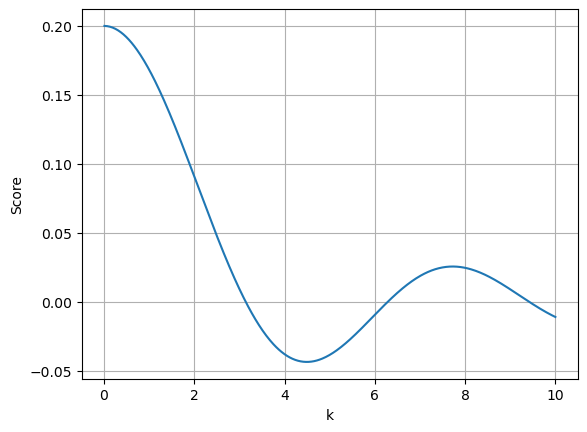

In [29]:
# example code of "vibration on a string"

import numpy as np
import matplotlib.pyplot as plt

def odefun1(x, y, k):
    return np.array([y[1], -k**2 * y[0]])

def rk4(f, x, y, k, h):  ## f is odefun1,  but how?
    k1 = h * f(x, y, k)
    k2 = h * f(x + h/2, y + k1/2, k)
    k3 = h * f(x + h/2, y + k2/2, k)
    k4 = h * f(x + h, y + k3, k)
    return y + (k1 + 2*k2 + 2*k3 + k4)/6


def caller_rk4(f, xlim, yini, k, N):
    x1, x2 = xlim
    xs = np.linspace(x1, x2, N)
    h = xs[1] - xs[0]
    y = yini
    ys = np.zeros((N, len(yini)))
    for i in range(N):
        ys[i] = np.array(y)
        y = rk4(f, xs[i], y, k, h)
    return xs, ys

def score(k, f, ybound):    ## difference y(L) - y_L
    xs, ys = caller_rk4(f, xlim, yini, k, N)
    return ys[-1][0] - ybound[1]

def secant(ks, f, method, ybound):  # method is score function,  but how?
    k1, k2 = ks
    iter = 0
    while abs(method(k2, f, ybound)) > tol and iter < maxiter:
        f1 = method(k1, f, ybound)
        f2 = method(k2, f, ybound)
        k1, k2 = k2, (f2*k1 - f1*k2)/(f2 - f1) # (f2*k1 - f1*k2)/(f2 - f1)= ??
        iter += 1
        print(iter, k1, k2, method(k2, f, ybound))
    return (iter, k2 if iter < maxiter else None)

def simp13(y,h):  ## area under curve
    store = y[0]**2 + y[-1]**2
    for i in range(2,len(y)):
        if i%2==0:
            store += 4*y[i]**2
        else:
            store += 2*y[i]**2
    return store*(h/3)


# Initialization
xlim = (0.0, 1.0)
yini = (0.0, 0.2) # 0.2 is an arbitrary number finally adjusted by normalization
# Boundary condition
ybound = (0.0, 0.0)
# Number of points
N = 129
# Max iteration and tolerance for secant
maxiter = 50
tol = 1.0e-6
ks = np.linspace(0.01,10,500);
scores = [score(k,odefun1,ybound) for k in ks];

plt.plot(ks, scores);
plt.grid();
plt.xlabel("k");
plt.ylabel("Score");



1 4.0 3.4122829393547915 -0.01567259463827126
2 3.4122829393547915 2.9967629583181297 0.0096319875472843
3 2.9967629583181297 3.154927327666126 -0.0008452980250207285
4 3.154927327666126 3.142166767870761 -3.654196514650716e-05
5 3.142166767870761 3.141590208442737 1.5626768057005504e-07


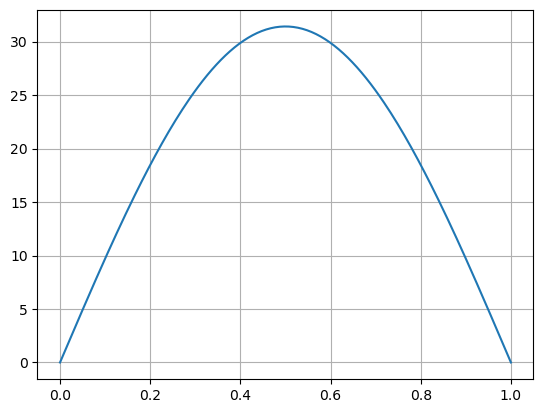

In [30]:
kini=(2.,4.);
iter,keigen = secant(kini,odefun1,score,ybound);  #this function return iteration number, K2 value

xs, ys = caller_rk4(odefun1,xlim,yini,keigen,200);
h = xs[1]-xs[0]
y1 = [y[0] for y in ys];
normfact = simp13(y1,h);
y2 = y1/normfact; #why normalising with area, instead divide with the max(y)
plt.plot(xs,y2);
plt.grid()
plt.show()

# y3 = y1/np.max(y1); #why normalising with area, instead divide with the max(y)
# plt.plot(xs,y3);
# plt.grid()
# plt.show()

Text(0.5, 1.0, 'Score vs Energy')

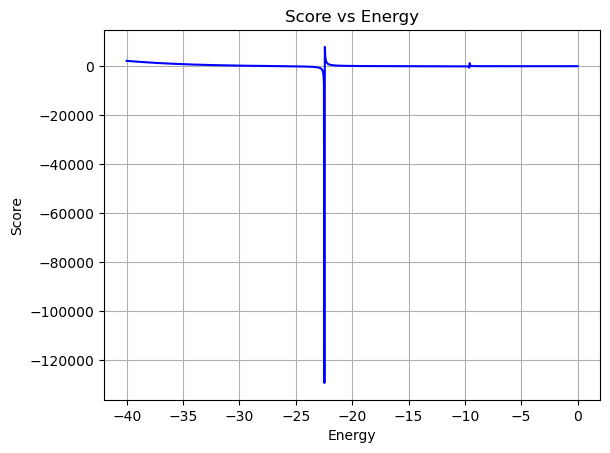

In [26]:
# example code of "bound state schrodinger"

import numpy as np
import matplotlib.pyplot as plt

# --- ODE Function for Schrödinger Equation ---
def odefun2(x, y, E):
    k2 = E - pot(x)
    return np.array([y[1], -k2 * y[0]])

# --- Finite Potential Well ---
def pot(x):
    if abs(x) > Lo:
        return 0.0
    else:
        return -Vo * (Lo - x) / 2

# --- RK4 Integrator ---
def rk4(f, x, y, k, h):
    k1 = h * f(x, y, k)
    k2 = h * f(x + h/2, y + k1/2, k)
    k3 = h * f(x + h/2, y + k2/2, k)
    k4 = h * f(x + h, y + k3, k)
    return y + (k1 + 2*k2 + 2*k3 + k4)/6

# --- RK4 Caller ---
def caller_rk4(f, xlim, yini, k, N):
    x1, x2 = xlim
    xs = np.linspace(x1, x2, N)
    h = xs[1] - xs[0]
    y = yini
    ys = np.zeros((N, len(yini)))
    for i in range(N):
        ys[i] = np.array(y)
        y = rk4(f, xs[i], y, k, h)
    return xs, ys

# --- Score Function: Match Derivatives at Turning Point ---
def score2(E, f, ybound):
    # Left solution
    yini1 = (ybound[0], 1.0e-2)
    xs1, ys1 = caller_rk4(f, xlim, yini1, E, N)
    a = abs(xs1 + Lo)  ###why??
    n1 = np.where(a == np.min(a))[0][0] ##whaatt???

    # Right solution (reversed integration)
    yini2 = (ybound[1], 1.0e-2)
    xs2, ys2 = caller_rk4(f, xlim[-1::-1], yini2, E, N)
    a = abs(xs2 + Lo)
    n2 = np.where(a == np.min(a))[0][0]

    # Scale to match at turning point
    ys2 = ys1[n1][0] * ys2 / ys2[n2][0]

    # Return slope mismatch
    return ys1[n1][1] - ys2[n2][1]  # difference in slope

# --- Secant Method ---
def secant(ks, f, method, ybound):
    k1, k2 = ks
    iter = 0
    while abs(method(k2, f, ybound)) > tol and iter < maxiter:
        f1 = method(k1, f, ybound)
        f2 = method(k2, f, ybound)
        k1, k2 = k2, (f2 * k1 - f1 * k2) / (f2 - f1)
        iter += 1
        print(iter, k1, k2, method(k2, f, ybound))
    return iter, (k2 if iter < maxiter else None)

# --- Parameters ---
Vo = 40.0
Lo = 1.0
xlim = (-3.0, 3.0)
ybound = (0.0, 0.0)
yini = (ybound[0], 0.1)
N = 129
maxiter = 50
tol = 1.0e-5

# --- Scan energy and plot score curve ---
Es = np.linspace(-Vo, 0, 1000)
scores = [score2(E, odefun2, ybound) for E in Es]

plt.plot(Es, scores, 'b-')
plt.grid()
plt.xlabel("Energy")
plt.ylabel("Score")
plt.title("Score vs Energy")



(-30.0, -20.0)

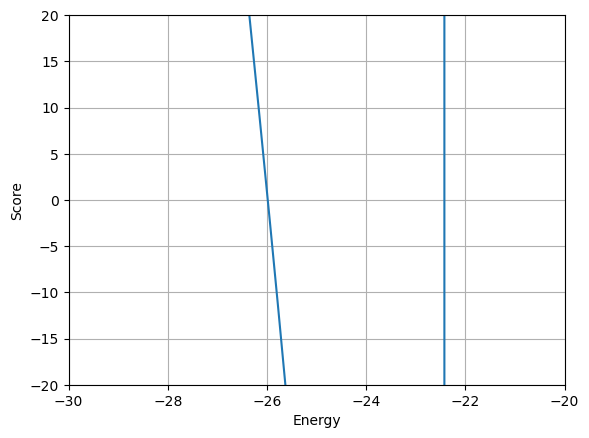

In [17]:
plt.plot(Es,scores);
plt.grid()
plt.xlabel("Energy");
plt.ylabel("Score");
plt.ylim([-20.,20.])
plt.xlim([-30.0,-20.0])

1 -25.8 -25.988074174980657 0.13420910734458857
2 -25.988074174980657 -25.985658192052604 0.0017136520619089879
3 -25.985658192052604 -25.985626944534587 -2.6050639689856325e-07


Text(0.5, 1.0, 'Bound state for E ≈ -25.98563')

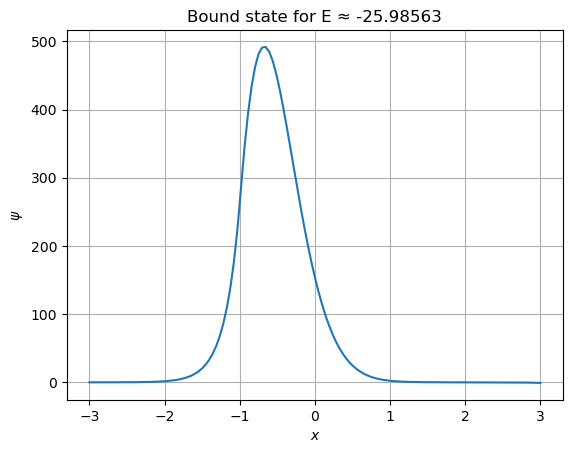

In [18]:
# --- Find eigenvalues using secant and plot eigenfunctions ---
# Example 1: First bound state

Eini = (-26.2, -25.8)
iter, Eeigen = secant(Eini, odefun2, score2, ybound)
xs, ys = caller_rk4(odefun2, xlim, yini, Eeigen, N)
y1 = [y[0] for y in ys]
plt.figure()
plt.plot(xs, y1)
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$\\psi$")
plt.title(f"Bound state for E ≈ {Eeigen:.5f}")

# You can repeat for more eigenvalues using different `Eini` ranges